In this script is the data smoothen after the PC are constructed 

In [2]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math
#for removing warnings
import warnings

In [3]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [4]:
dset = open_s3fs('PC-data')
dset

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [5]:
# Smoothen data, over every tenth point in both x and y direction, for all the data
vvar = dset.vomecrty.isel(y=slice(900,1800), x=slice(200,1400)).rolling(y=10, center=True).mean()
vvar = vvar.rolling(x=10, center=True).mean()

uvar = dset.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400)).rolling(x=10, center=True).mean()
uvar = uvar.rolling(y=10, center=True).mean()

uv = dset.vel.isel(y=slice(900,1800), x=slice(200,1400)).rolling(x=10, center=True).mean()
uv = uv.rolling(y=10, center=True).mean()

In [6]:
# Getting the bottom velocity 
d = dset.mbathy[900:1800,200:1400].values-1
d[d==-1] = 0

d = xr.DataArray(d, dims=['y','x'])

uvar_b = uvar.isel(depth=d)
vvar_b = vvar.isel(depth=d)
uv_b = uv.isel(depth=d)

The bottom current when the data have been smoothened before constructing the PC

In [8]:
# Making the covmatrix and finding the eigenvalues and eigenvectors
# list of all the points for the PC-crosses

dx = 20
dy = 20
# Making empty list with size as data-points 
jmax, imax = uv[0].shape #fetches the max value in j and i direction 
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

PC11_s = []
PC12_s = []
PC21_s = []
PC22_s = []
y = []
x = []
indx =0
    
# to get the loop to run faster
uvy_s = np.array(uv_b.y.values)
uvx_s = np.array(uv_b.x.values)
    
# fetching the varaibel at the given level 
uvar_s = np.array(uvar_b.values)
vvar_s = np.array(vvar_b.values)
uv_s = np.array(uv_b.values)
    
for i in i_list:
        for j in j_list:
            covm = np.array([[uvar_s[j,i],uv_s[j,i]],
            [uv_s[j,i],vvar_s[j,i]]],dtype=float)
            if np.isnan(covm).any():
                continue
            else:
                values, vectors = np.linalg.eig(covm)
                PC11_s.append(vectors[0,0]*np.sqrt(values[0]))
                PC12_s.append(vectors[1,0]*np.sqrt(values[0]))
                PC21_s.append(vectors[0,1]*np.sqrt(values[1]))
                PC22_s.append(vectors[1,1]*np.sqrt(values[1]))
                y.append(uvy_s[j])
                x.append(uvx_s[i])
                indx = indx + 1
                
                # Find and sort eigenvalues and eigenvectors into descending order
                order = values.argsort()[::-1]
                values, vectors = values[order], vectors[:, order]

                # The anti-clockwise angle to rotate our ellipse by 
                vx, vy = vectors[:,0][0], vectors[:,0][1]
                theta = np.arctan2(vy, vx)
                nstd = 3 #bestemt selv, tilsvarer 98.9% av dataen (skjønner ikke helt dette) number of standard deviations

                # Width and height of ellipse to draw
                width, height = 2 * nstd * np.sqrt(eigvals)
                return Ellipse(xy=centre, width=width, height=height,
                                angle=np.degrees(theta), **kwargs)
                
                
                
                
                
# converting to np.arrays
PC11_s = np.array(PC11_s,dtype=float)
PC12_s = np.array(PC12_s,dtype=float)
PC21_s = np.array(PC21_s,dtype=float)
PC22_s = np.array(PC22_s,dtype=float)
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)


In [30]:
def confidence_ellipse(cov, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    
  # Find and sort eigenvalues and eigenvectors into descending order
    values, vectors = np.linalg.eig(covm)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = vectors[:,0][0], vectors[:,0][1]
    theta = np.arctan2(vy, vx)
    nstd = 3 #bestemt selv, tilsvarer 98.9% av dataen (skjønner ikke helt dette) number of standard deviations

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(values)
    ellipse = Ellipse(xy=(0,0), width=width, height=height,
                    angle=np.degrees(theta), **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

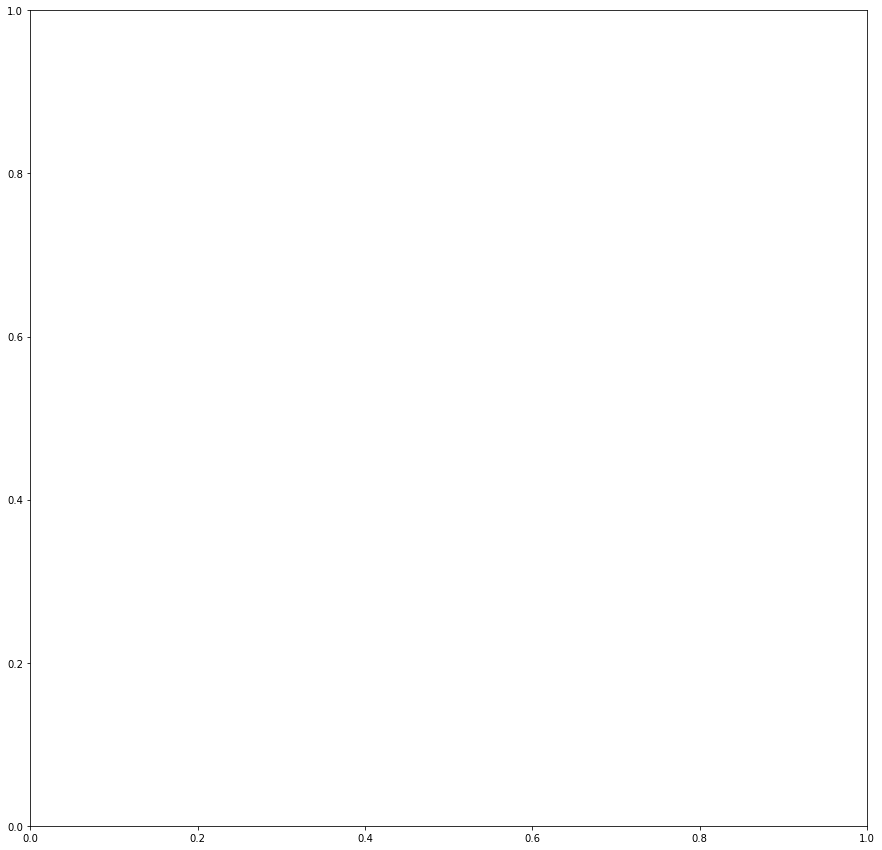

In [32]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

fig, ax = plt.subplots(1,1,figsize=(15,15))

for i in i_list:
        for j in j_list:
            covm = np.array([[uvar_s[j,i],uv_s[j,i]],
            [uv_s[j,i],vvar_s[j,i]]],dtype=float)
            if np.isnan(covm).any():
                continue
            else:
                e = confidence_ellipse(covm, n_std=3.0, facecolor='none')
                ax.add_artist(e)

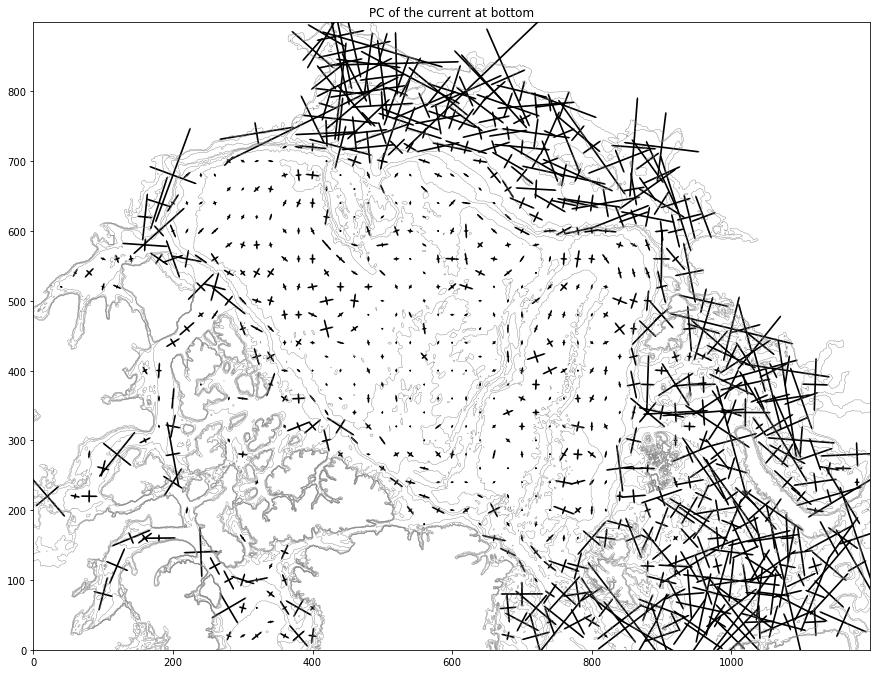

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at bottom')
ax.contour(dset.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::2], y[::2], PC11_s[::2], PC12_s[::2], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver(x[::2], y[::2], -PC11_s[::2], -PC12_s[::2],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::2], y[::2], PC21_s[::2], PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::2], y[::2], -PC21_s[::2], -PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.set_aspect('equal')
plt.show()

Fig. XX shows the bottom current 65.65 to 59,25 degree North, and -89,19 to 114.87 degree East. The largest variance of the currents can be found on the shallower areas, as exemple on the shelf or in the Barents sea. The Bering strait, which has an average depth of 50m (https://www.britannica.com/place/Bering-Strait), shows a larger variance than the Fram stait, which is significantly deeper. 

The variance is weakest at the deeper parts of the arctic ocean. It is also here we can find the clearest signal of topogtaphic steering.   

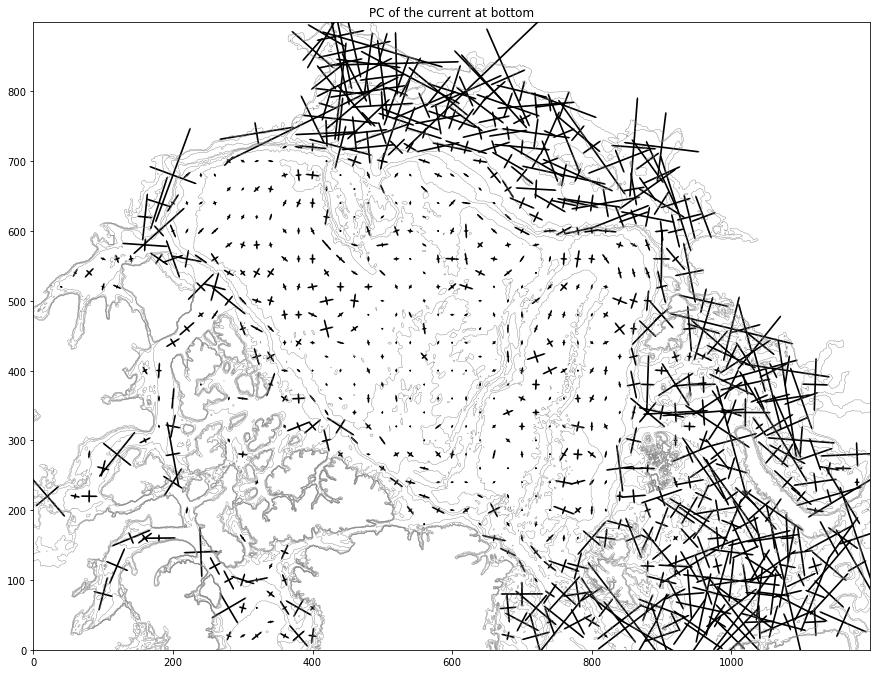

In [16]:
from matplotlib.patches import Ellipse

n = 2
fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at bottom')
ax.contour(dset.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::n], y[::n], PC11_s[::n], PC12_s[::n], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver(x[::n], y[::n], -PC11_s[::n], -PC12_s[::n],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::n], y[::n], PC21_s[::n], PC22_s[::n],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::n], y[::n], -PC21_s[::n], -PC22_s[::n],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)

major_ax = (1/np.sqrt(values[0]))
minor_ax = (1/np.sqrt(values[1]))



#e = Ellipse((x[::2], y[::2]), width = major_ax[::2] , height = minor_ax[::2] ,edgecolor='r',facecolor='none')
#fig.add_artist(e)



ax.set_aspect('equal')
plt.show()